In [101]:
import os
import glob
import pickle
from collections import defaultdict

import numpy as np
from torch import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
root = '.\\results\\grad-norm\\'
param_norms = defaultdict(list)

for fn in glob.glob(root + '**/params/iter-*.pkl', recursive=True):
    dataset, gnn, dropout, prob, _, batch = fn.lstrip(root).split('\\')
    prob = float(prob.split('=')[1]) / 100.
    batch = int(os.path.splitext(batch)[0].split('-')[1])
    with open(fn, 'rb') as f:
        param_norms[(gnn, dropout, prob)].append(norm(pickle.load(f), p=2).item())

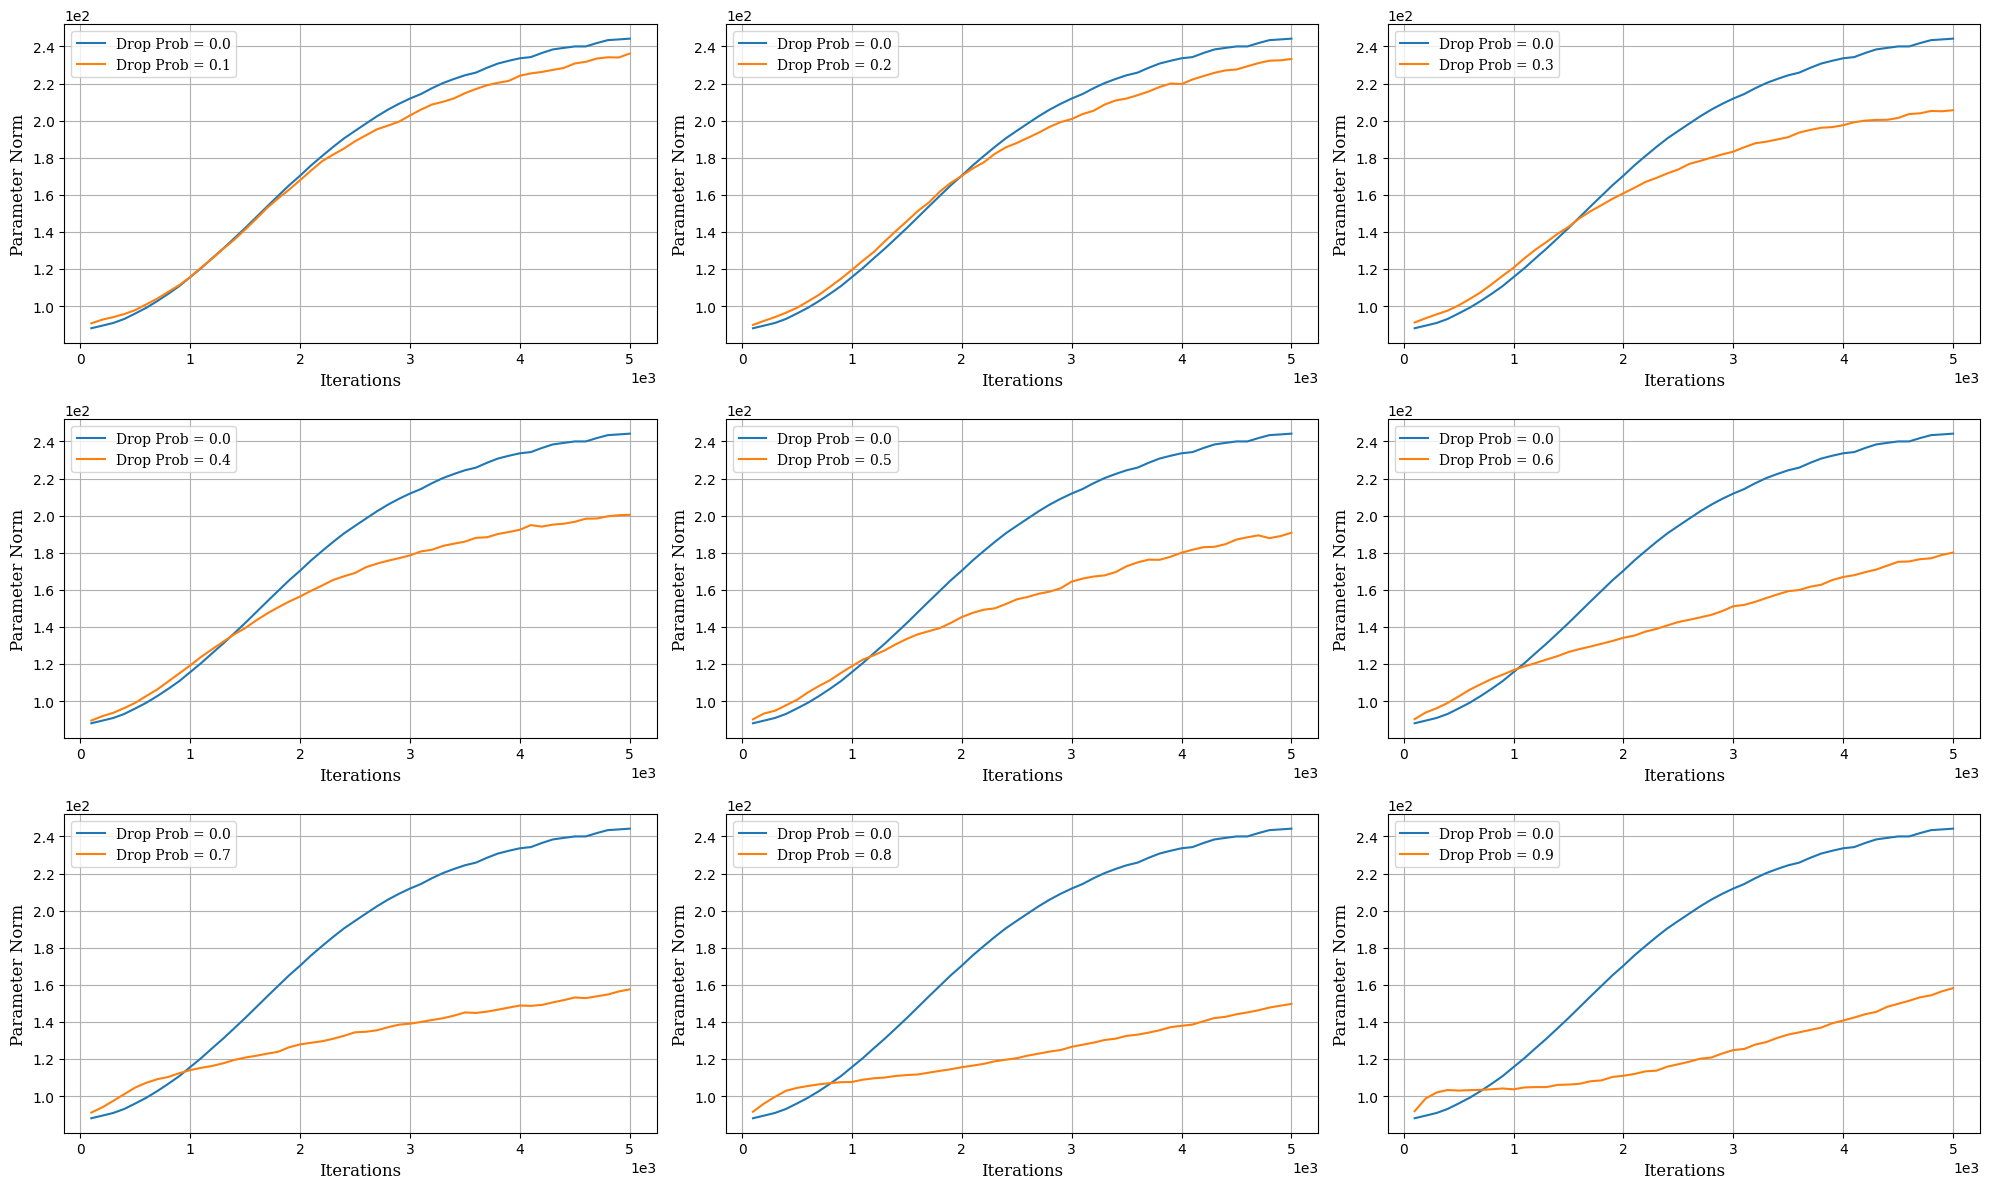

In [105]:
fontdict = {'font':'serif', 'size':12}
fig, axs = plt.subplots(3, 3, figsize=(20,12))
step = 100; batches = range(step, 5001, step)

for i, drop_p in enumerate(range(10, 91, 10)):
    
    ax = axs[i//3, i%3]; drop_p = drop_p / 100
    for p in (0.0, drop_p):
        norms = param_norms.get(('GCN', 'Dropout', p), None)
        if norms is None: continue
        y = [norms[batch//100-1] for batch in batches]
        ax.plot(batches, y, label=f'Drop Prob = {p}')

    ax.set_xlabel('Iterations', fontdict=fontdict)
    ax.set_ylabel('Parameter Norm', fontdict=fontdict)
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax.grid()
    ax.legend(prop={'family':fontdict['font'],'size':fontdict['size']-2})

fig.tight_layout()
plt.show()

In [77]:
root = '.\\results\\grad-norm\\'
final_params = dict()

for fn in glob.glob(root + '**/params/iter-5000.pkl', recursive=True):
    dataset, gnn, dropout, prob, _, batch = fn.lstrip(root).split('\\')
    prob = float(prob.split('=')[1]) / 100.
    batch = int(os.path.splitext(batch)[0].split('-')[1])
    with open(fn, 'rb') as f:
        final_params[(gnn, dropout, prob)] = pickle.load(f).numpy()

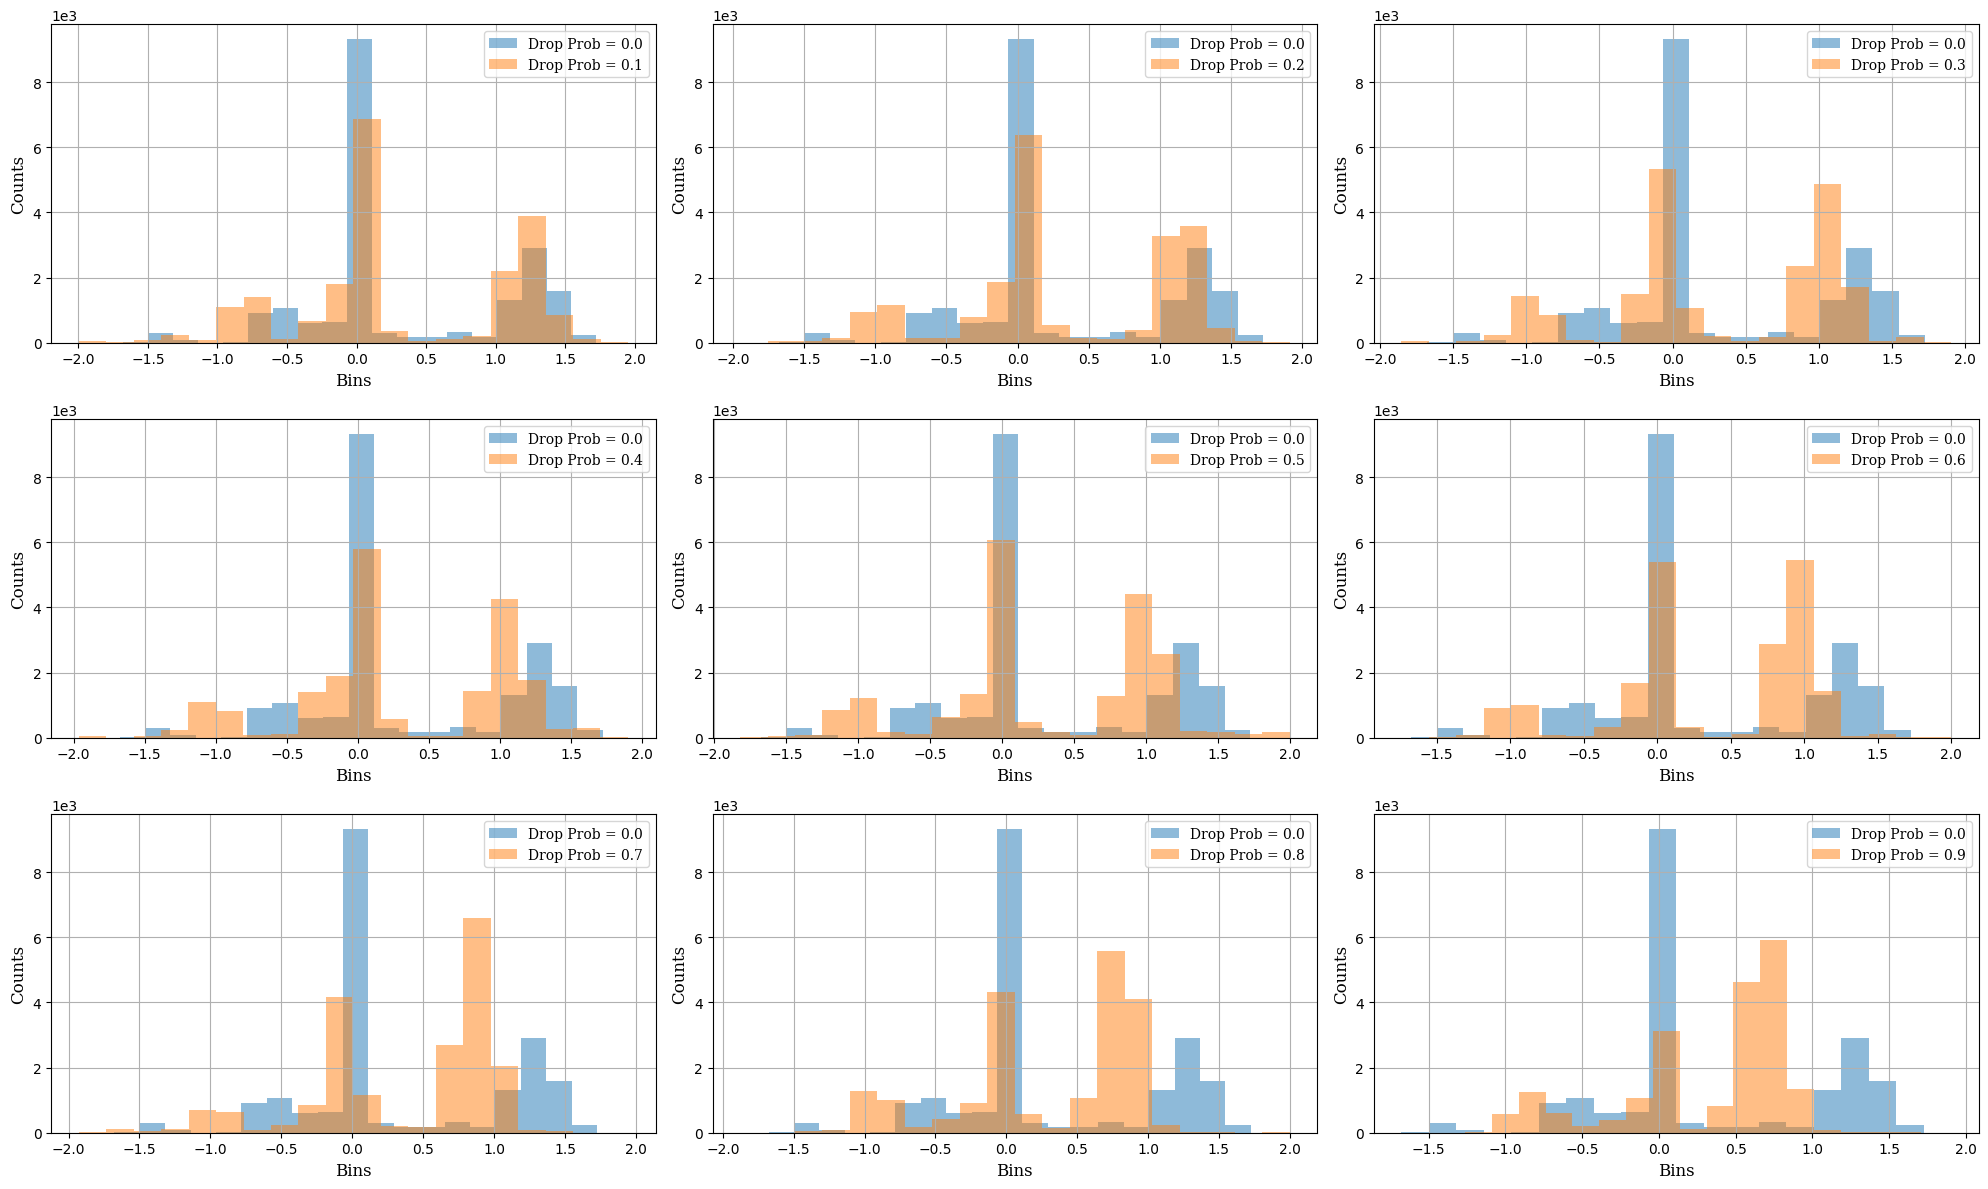

In [89]:
fontdict = {'font':'serif', 'size':12}
fig, axs = plt.subplots(3, 3, figsize=(20,12))

for i, drop_p in enumerate(range(10, 91, 10)):
    
    ax = axs[i//3, i%3]; drop_p = drop_p / 100
    for p in (0.0, drop_p):
        params = final_params.get(('GCN', 'Dropout', p), None)
        if params is None: continue
        params = params[np.where(np.abs(params)<=2.)]
        ax.hist(params, bins=20, alpha=0.5, label=f'Drop Prob = {p}', )

    ax.set_xlabel('Bins', fontdict=fontdict)
    ax.set_ylabel('Counts', fontdict=fontdict)
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax.grid()
    ax.legend(prop={'family':fontdict['font'],'size':fontdict['size']-2})

fig.tight_layout()
plt.show()

In [106]:
root = '.\\results\\grad-norm\\'
grad_norms = defaultdict(list)

for fn in glob.glob(root + '**/grads/iter-*.pkl', recursive=True):
    dataset, gnn, dropout, prob, _, batch = fn.lstrip(root).split('\\')
    prob = float(prob.split('=')[1]) / 100.
    batch = int(os.path.splitext(batch)[0].split('-')[1])
    with open(fn, 'rb') as f:
        grad_norms[(gnn, dropout, prob)].append(norm(pickle.load(f), p=2).item())

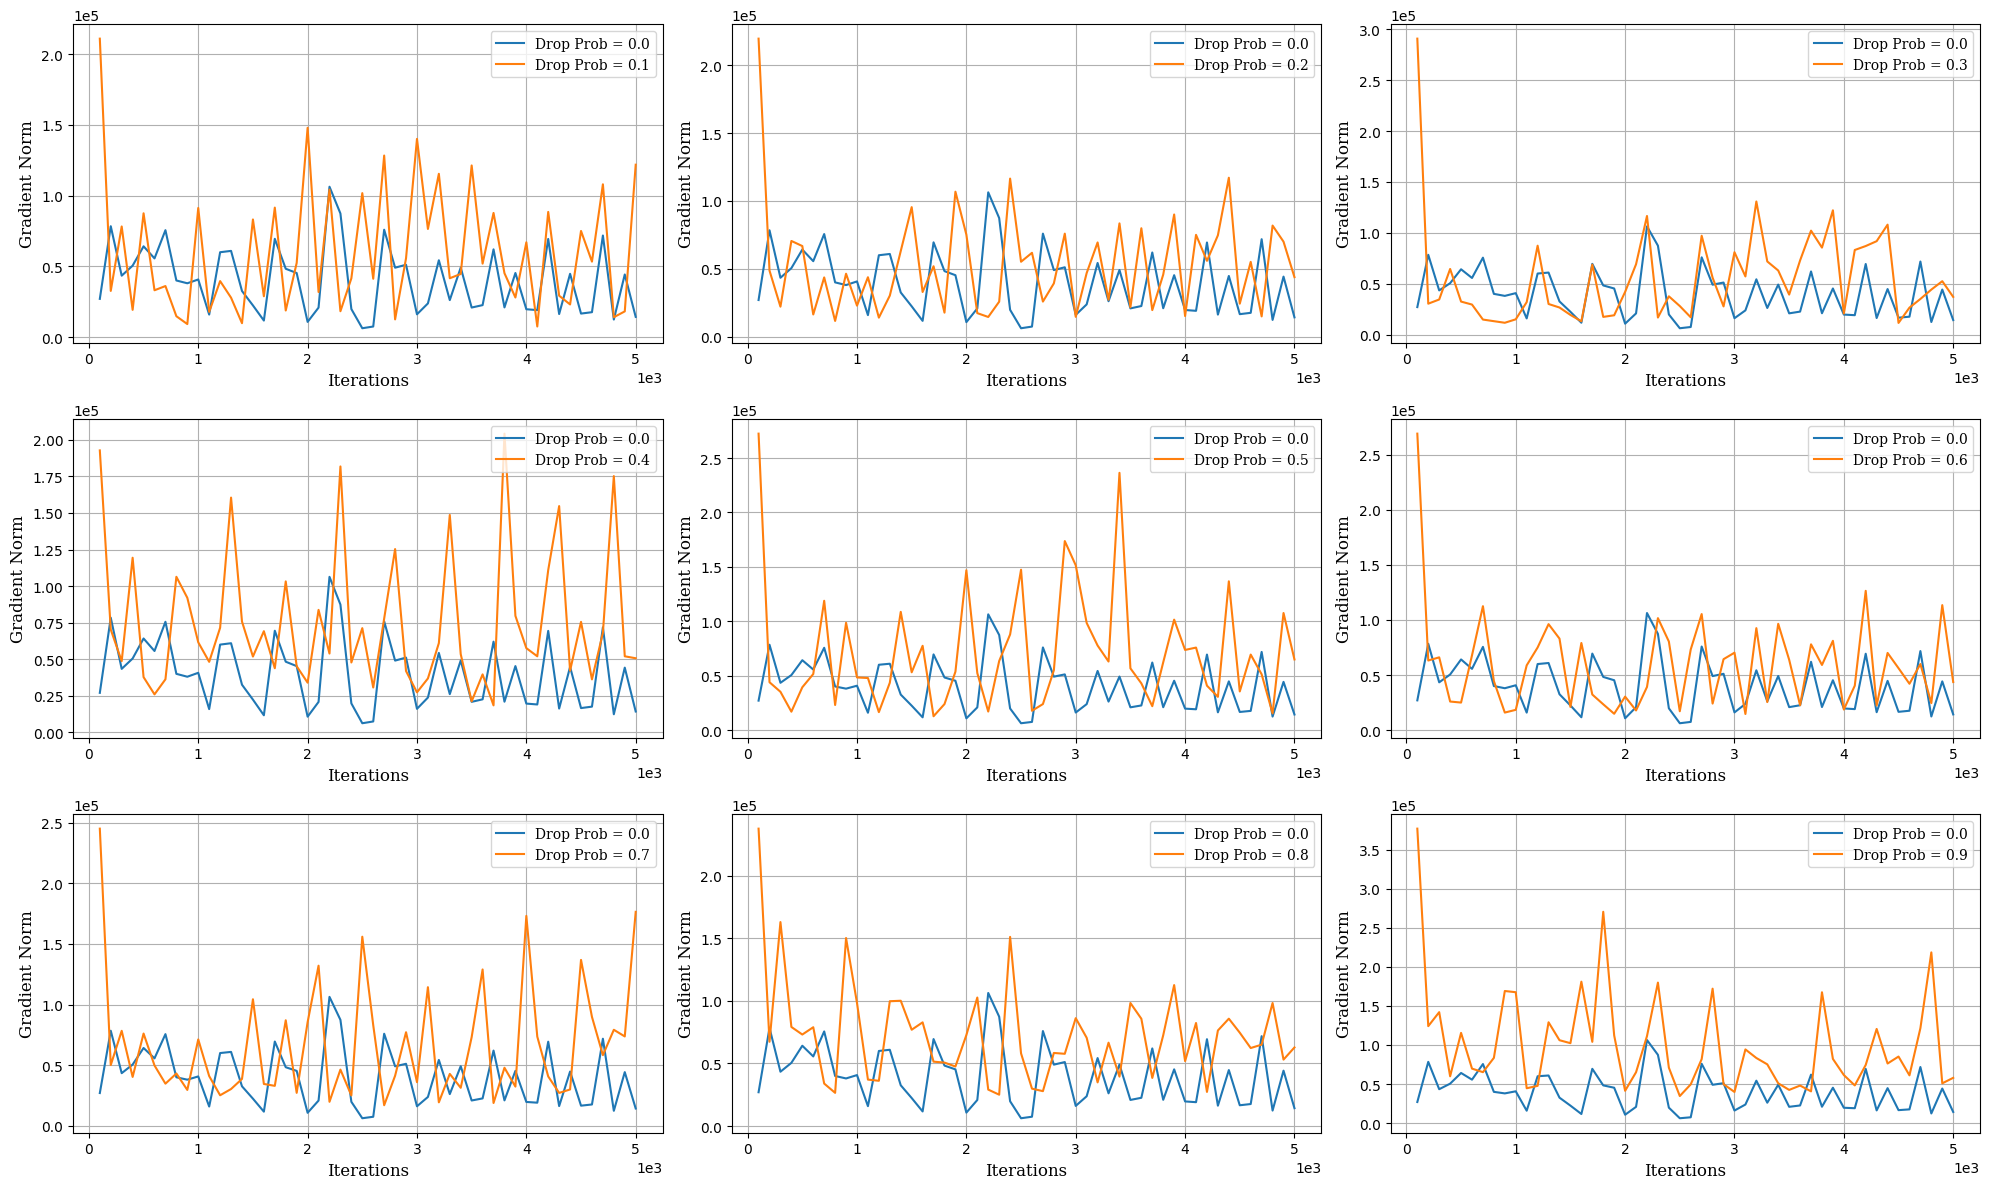

In [107]:
fontdict = {'font':'serif', 'size':12}
fig, axs = plt.subplots(3, 3, figsize=(20,12))
step = 100; batches = range(step, 5001, step)

for i, drop_p in enumerate(range(10, 91, 10)):
    
    ax = axs[i//3, i%3]; drop_p = drop_p / 100
    for p in (0.0, drop_p):
        norms = grad_norms.get(('GCN', 'Dropout', p), None)
        if norms is None: continue
        y = [norms[batch//100-1] for batch in batches]
        ax.plot(batches, y, label=f'Drop Prob = {p}')

    ax.set_xlabel('Iterations', fontdict=fontdict)
    ax.set_ylabel('Gradient Norm', fontdict=fontdict)
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax.grid()
    ax.legend(prop={'family':fontdict['font'],'size':fontdict['size']-2})

fig.tight_layout()
plt.show()